### Introduction: 
#### One of the sustainable ways to generate energy is from wind. Not all locations are suitable for wind energy generation. This requires proper inspection and analysis to install wind turbines. Right location, height of the turbine will be more beneficial.
#### This analysis answers the following questions:
#### 1. What is the optimal height for the turbine that generates more energy?
#### 2. What is correlation between rotor diameter with the energy production?
#### 3. Which area South(Elevated areas)  or North(Coastal areas) is suitable for wind energy?
#### 4. Which company is more successful in this domain wrt generating energy and analysis on their turbines specification?
#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Importing Dependencies

In [137]:
import requests
import pandas as pd
import gdown
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import folium #Folium is the library used visualize spatial data'''
from geopy.geocoders import Nominatim  #My dataset do not have geograpgical coordinates, so this library will be use in fetching those

##### I am using two wind energy datasets from Bavaria and Schleswig-Holstein which is the coastal region of Germany.
##### Bayern data is hosted on my google drive because there is no link for this dataset, CSV is generated by Javascript after selecting several buttons and selecting different options. To automate this process needed website automation or Selenium. So I am using gdown library to download data from google drive
##### Original Bavaria Dataset source: https://www.karten.energieatlas.bayern.de
##### Original Schleswig-Holstein Dataset source: https://opendata.schleswig-holstein.de/dataset


In [3]:
''' Functions to download (load) both datasets '''

def download_bayernData(url):
    !gdown --fuzzy {url} -O BayernData.csv
    bayern_data = pd.read_csv("BayernData.csv",on_bad_lines='skip')
    return bayern_data

In [4]:
def download_schleswigData(url):
    response = requests.get(url)
    with open("SchleswigData.xlsx","wb") as file:
        file.write(response.content)
    schleswigData = pd.read_excel("SchleswigData.xlsx")
    return schleswigData

#### Following are the functions to transform, pre-process the extracted data, to make it ready for analysis.

In [5]:
 '''
     
    Transforming and Cleaning data includes:
    --selecting columns relevant for data analysis
    --renaming/translating column names
    --extract just the first word from company name and make them uppercase to show it in map visualization
    --Dropping null records
    --Changing datatypes
    --dropping duplicate locations and selecting only the first occurence of the each location
    
    Note: Reason for using is that the columns we need from the datasets are on different indexes in both datasets.
    
    '''

def transform_bayernData(extractedData):
    selectedColumns = extractedData[["Name","Leistung (kW)","Gesamthöhe (m)","Rotordurchmesser (m)","Hersteller"]]
    renamedData = selectedColumns.rename(columns={"Name": "Location", "Leistung (kW)": "Power Generation(kW)","Gesamthöhe (m)":"Turbine Height (m)","Rotordurchmesser (m)":"Rotor Diameter (m)","Hersteller":"Company"})
    renamedData['Company'] = renamedData['Company'].str.split().str[0].str.upper()
    removedNull = renamedData[~renamedData['Company'].str.contains('UNBEKANNT')].copy()
    removedNull = removedNull[~removedNull['Turbine Height (m)'].str.contains('unbekannt')].copy()
    removedNull = removedNull.drop_duplicates(subset='Location', keep='first')
    removedNull['Turbine Height (m)'] = removedNull['Turbine Height (m)'].astype(float)
    removedNull['Rotor Diameter (m)'] = removedNull['Rotor Diameter (m)'].astype(float)
    cleanedData = removedNull
    return cleanedData

In [6]:
def transform_schleswigData(extractedData):
    selectedColumns=extractedData[["GEMEINDE","LEISTUNG","NABENHOEHE","ROTORDURCHMESSER","HERSTELLER"]]
    renamedData=selectedColumns.rename(columns={"GEMEINDE": "Location", "LEISTUNG": "Power Generation(kW)","NABENHOEHE":"Turbine Height (m)","ROTORDURCHMESSER":"Rotor Diameter (m)","HERSTELLER":"Company"})
    renamedData['Company'] = renamedData['Company'].str.split().str[0].str.upper()
    removedNull=renamedData[~renamedData['Company'].str.contains('HERSTELLER')].copy()
    removedNull=removedNull.dropna(subset=['Turbine Height (m)'])
    removedNull=removedNull.drop_duplicates(subset='Location', keep='first')
    removedNull['Turbine Height (m)'] = removedNull['Turbine Height (m)'].apply(lambda x: float(x.replace(',', '.')))
    removedNull['Rotor Diameter (m)'] = removedNull['Rotor Diameter (m)'].apply(lambda x: float(x.replace(',', '.')))
    cleanedData=removedNull
    return cleanedData

In [7]:
'''Calling the Extract and transform functions'''

#Extracting data..
bayernData=download_bayernData("https://drive.google.com/file/d/1_ldLqz8O1XrEj8Px7nf8AHhsq00VHDCW/view?usp=sharing")
schleswigData=download_schleswigData("https://opendata.zitsh.de/data/llur72/opendata_WKA_ib_gv_vb_SH_200201019.xlsx")

#Transforming the data..
transformedbayernData=transform_bayernData(bayernData)
transformedschleswigData=transform_schleswigData(schleswigData)

Downloading...
From: https://drive.google.com/uc?id=1_ldLqz8O1XrEj8Px7nf8AHhsq00VHDCW
To: C:\Users\usman.kamran\Made PW3\BayernData.csv

  0%|          | 0.00/258k [00:00<?, ?B/s]
100%|##########| 258k/258k [00:00<00:00, 7.94MB/s]


#### Explore the transformed data..

In [8]:
transformedschleswigData.head(10)

,Location,Power Generation(kW),Turbine Height (m),Rotor Diameter (m),Company
0,Kiel,3000.0,134.0,131.0,NORDEX
3,Lübeck,2300.0,85.0,82.0,ENERCON
6,Albersdorf,3300.0,119.0,112.0,VESTAS
12,Barlt,500.0,40.5,39.0,VESTAS
33,Brunsbüttel,3400.0,80.0,104.0,REPOWER
92,Diekhusen-Fahrstedt,2300.0,108.0,82.0,ENERCON
96,Volsemenhusen,5700.0,105.0,149.0,NORDEX
103,Schmedeswurth,3000.0,92.0,115.7,ENERCON
106,Dingen,3400.0,80.0,104.0,REPOWER
114,Süderhastedt,3200.0,93.0,114.0,REPOWER


In [9]:
transformedbayernData.head(10)

,Location,Power Generation(kW),Turbine Height (m),Rotor Diameter (m),Company
0,Aub,2000.0,140.0,80.0,VESTAS
1,Bieberehren,1500.0,150.0,82.0,NEG
2,Riedenheim,1500.0,151.0,82.0,VESTAS
3,Bütthard,1500.0,150.0,82.0,VESTAS
4,Kirchheim,600.0,99.9,44.0,ENERCON
6,Rothenburg ob der Tauber,800.0,100.0,52.9,NORDEX
7,Feilitzsch,1500.0,135.0,77.0,GE
8,Töpen,1500.0,135.0,77.0,GE
11,Kitzingen,2000.0,150.0,90.0,VESTAS
12,München,1500.0,100.0,66.0,ENERCON


In [10]:
print("Maximum wind energy generation in a location in Bavaria in KWs:",transformedbayernData['Power Generation(kW)'].max())

Maximum wind energy generation in a location in Bavaria in KWs: 4800.0


In [11]:
print("Maximum wind energy generation in a location in Schleswig-Holstein in KWs:",transformedschleswigData['Power Generation(kW)'].max())

Maximum wind energy generation in a location in Schleswig-Holstein in KWs: 7500.0


In [12]:
print("Maximum height of a turbine in Bavaria in meters:",transformedbayernData['Turbine Height (m)'].max())

Maximum height of a turbine in Bavaria in meters: 240.0


In [13]:
print("Maximum height of a turbine in Schleswig-Holstein in meters:",transformedschleswigData['Turbine Height (m)'].max())

Maximum height of a turbine in Schleswig-Holstein in meters: 169.0


In [14]:
print("List of Companies operating: ", pd.concat([transformedbayernData['Company'], transformedschleswigData['Company']]).unique())

List of Companies operating:  ['VESTAS' 'NEG' 'ENERCON' 'NORDEX' 'GE' 'SONSTIGE' 'DEWIND' 'TACKE'
 'LAGERWEY' 'PFLEIDERER' 'KÄHLER' 'SONKYO' 'AN' 'SÜDWIND' 'INVENTUS'
 'FUHRLÄNDER' 'SENVION' 'REPOWER' 'SIEMENS' 'SEEWIND' 'HSW' 'BRAUN'
 'GAMESA' 'HEYDE' 'WITTENBAUER' 'FUSYSTEMS' 'HOME' 'ANHUI' 'LELY' 'HYDEN'
 'VENSYS' 'VWA-DEUTSCHLAND' 'EUSAG' 'AEOLOS' 'KESSLER' 'MYWIND' 'TOZZI'
 'EASYWIND' 'PSW-ENERGIESYSTEME' 'NORDTANK' 'MICON' 'HANSEATISCHE' 'WIND'
 'JACOBS']


#### Lets see visually where these turbines in North and South regions are installed using an iteractive map
##### Note: Use this link to see the interactive map
##### https://nbviewer.org/github/K-Usman/MADE-FAU/blob/main/project/report.ipynb

In [28]:
geolocator = Nominatim(user_agent="example")
def create_map(dataset,state,location):
    ''' This function is fetching the coordinates against each town and then creating a map.
    function accepts the argument state  because one town can be located in multiple states or even countries
    so specifying the state of interest i.e Bayern and Schleswig-Holstein will help me fetch the coorinates from
    the right state. Location as coordinates argument is used to specify the area
    '''
    dataset['coordinates']=np.nan #creating a null column to store coordinates in dataframe
    coordinates = []
    for k in dataset['Location']:
        loc = geolocator.geocode(f'{k}, {state}').raw  #here this method takes a string as 'Lindau, Schleswig-Holestein'
        cordinate=(loc['lat'], loc['lon'])
        coordinates.append(cordinate)
    dataset['coordinates']=coordinates
    
    map_zoo = folium.Map(location=location, zoom_start=7)
    for i,r in dataset.iterrows():
        label=f'''{r['Location']} <br>
        Power Generation: {r['Power Generation(kW)']} <br>
        Turbin Height: {r['Turbine Height (m)']} <br>
        Rotor Diameter: {r['Rotor Diameter (m)']} '''
        folium.Marker(location=r['coordinates'],
                      popup = r['Location'],
                      tooltip=label ).add_to(map_zoo)
    return map_zoo

In [22]:
create_map(transformedschleswigData,"Schleswig-Holstein",[54,10])
print("Hover over the markers to see more details")

In [29]:
create_map(transformedbayernData,"Bayern",[49,12])
print("Hover over the markers to see more details")

#### Lets see which company has more presence in Bavaria and Schleswig

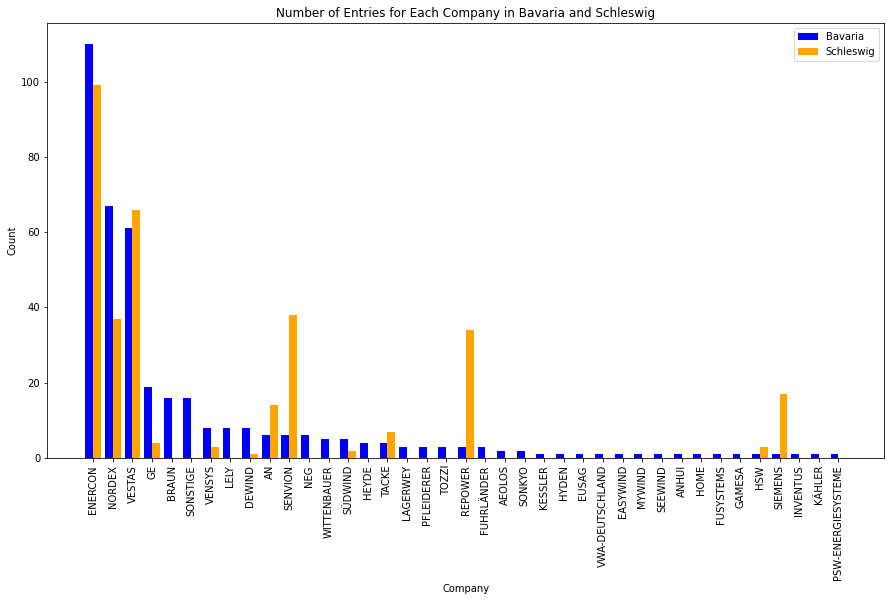

In [64]:
counts_south = transformedbayernData['Company'].value_counts()
counts_north = transformedschleswigData['Company'].value_counts()

company_counts = pd.DataFrame({
    'Company': counts_south.index,
    'Bavaria': counts_south.values,
    'Schleswig': counts_north.reindex(counts_south.index, fill_value=0).values
})

# Set the company column as the index
company_counts.set_index('Company', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

# Bar width
bar_width = 0.40

# X-axis positions
r1 = range(len(company_counts))
r2 = [x + bar_width for x in r1]

# Plot bars
ax.bar(r1, company_counts['Bavaria'], color='blue', width=bar_width, label='Bavaria')
ax.bar(r2, company_counts['Schleswig'], color='orange', width=bar_width, label='Schleswig')

# Customize the chart
ax.set_xticks([r + bar_width / 2 for r in range(len(company_counts))])
ax.set_xticklabels(company_counts.index, rotation=90)
ax.set_xlabel('Company')
ax.set_ylabel('Count')
ax.set_title('Number of Entries for Each Company in Bavaria and Schleswig')
ax.legend()


# 

#### Average power generation between North and South region

In [67]:
print("Statistics of Schleswig-Holstein Turbines")
transformedschleswigData.describe()

Statistics of Schleswig-Holstein Turbines


,Power Generation(kW),Turbine Height (m),Rotor Diameter (m)
count,343.000000,343.000000,343.000000
mean,2787.930029,89.856210,98.416676
std,1349.136425,26.458312,32.671965
min,150.000000,32.000000,27.000000
25%,2000.000000,65.000000,71.000000
50%,3000.000000,92.500000,104.000000
75%,3400.000000,108.000000,116.800000
max,7500.000000,169.000000,162.000000


In [65]:
print("Statistics of Bavarian Turbines")
transformedbayernData.describe()

Statistics of Bavarian Turbines


,Power Generation(kW),Turbine Height (m),Rotor Diameter (m)
count,384.000000,384.00000,384.000000
mean,1611.997656,130.25625,72.494271
std,1105.185973,66.60156,40.827718
min,0.500000,4.00000,1.000000
25%,600.000000,87.00000,44.000000
50%,2000.000000,150.00000,82.000000
75%,2400.000000,196.00000,112.000000
max,4800.000000,240.00000,158.000000


##### the average power generation in the coastal areas is more despite the fact that average height of turbine in Bavaria is more(assuming that turbines with more height produces energy. Lets find out below if its true or not)

# 

#### Correlation between Turbine height and energy production 

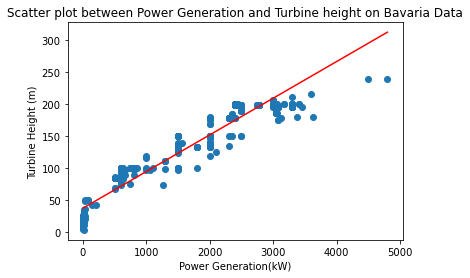

In [92]:
plt.scatter(transformedbayernData['Power Generation(kW)'], transformedbayernData['Turbine Height (m)'])
plt.plot(np.unique(transformedbayernData['Power Generation(kW)']), np.poly1d(np.polyfit(transformedbayernData['Power Generation(kW)'], transformedbayernData['Turbine Height (m)'], 1))
         (np.unique(transformedbayernData['Power Generation(kW)'])), color='red')
plt.title("Scatter plot between Power Generation and Turbine height on Bavaria Data")
plt.xlabel("Power Generation(kW)")
plt.ylabel("Turbine Height (m)")
plt.show()

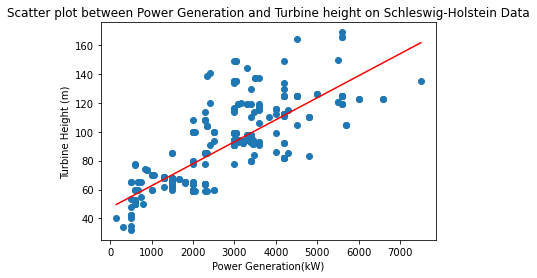

In [93]:
plt.scatter(transformedschleswigData['Power Generation(kW)'], transformedschleswigData['Turbine Height (m)'])
plt.plot(np.unique(transformedschleswigData['Power Generation(kW)']), np.poly1d(np.polyfit(transformedschleswigData['Power Generation(kW)'], transformedschleswigData['Turbine Height (m)'], 1))
         (np.unique(transformedschleswigData['Power Generation(kW)'])), color='red')
plt.title("Scatter plot between Power Generation and Turbine height on Schleswig-Holstein Data")
plt.xlabel("Power Generation(kW)")
plt.ylabel("Turbine Height (m)")
plt.show()

#### We can say that turbine height is positively correlated with power generation 

# 

## Conclusion 
#### After the above analysis we can say that:
#### 1. The wind energy production is more in the Coastal areas which is Schleswig-Holstein region than in Bavaria region.
#### suggestion: We can increase the installation of turbines on coastal areas to benefit from this.
#### 2. There has been a strong positive correlation between Turbine Height and Power Generation, which means turbines with tall height produces more energy as compares to ones with short height.
#### 3. If we talk about companies. Enercon, Nordex and Vestas are the top providers.

# 

## Further Research: 
#### We saw that coastal areas produces more energy than the areas on the south. But to go in more detail and to know what areas are best for renewable energy production we can combine climate data with this analysis and what weather is suitable like wind speed and what areas of country are more windy